In [1]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub/')
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync/')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
sl.Defaults['parallel']=False
plt.rcParams.update({'font.size': 14})

In [2]:
%matplotlib notebook

In [3]:
# Some constants
dCC=sl.Tools.dipole_coupling(.154,'13C','13C')
dHC=sl.Tools.dipole_coupling(.109,'1H','13C')

# Rotary Resonance
Two spins, separated by the MAS frequency, will transfer magnetization between them, without any outside influence. At 15 kHz MAS, and 600 MHz Larmor frequency, rotary resonance occurs for a difference of chemical shift of 100 ppm. We'll try both on and off rotary resonance.

In [335]:
ex=sl.ExpSys(600,Nucs=['13C','13C'],vr=15000,pwdavg=sl.PowderAvg(q=4),n_gamma=30)
ex.set_inter('dipole',delta=dCC,i0=0,i1=1)
ex.set_inter('CS',ppm=-15,i=1)
ex.set_inter('CS',ppm=10,i=0)

L=ex.Liouvillian()
seq=L.Sequence()
seq.add_channel('13C',t=[0,L.taur/2])

Cx=sl.Rho('13Cx','13Cp')
Cx.DetProp(seq,n=1024)

Cz=sl.Rho('S0z',['S0z','S1z'])
Cz.DetProp(seq,n=256)

ex.set_inter('CS',ppm=85,i=0)
L=ex.Liouvillian()
seq=L.Sequence()
seq.add_channel('13C',t=[0,L.taur/2])

CxRR=sl.Rho('13Cx','13Cp')
CxRR.DetProp(seq,n=1024)

CzRR=sl.Rho('S0z',['S0z','S1z'])
_=CzRR.DetProp(seq,n=256)

Prop: 2 steps per every 1 rotor period
Prop: 2 steps per every 1 rotor period
Prop: 2 steps per every 1 rotor period
Prop: 2 steps per every 1 rotor period


<IPython.core.display.Javascript object>


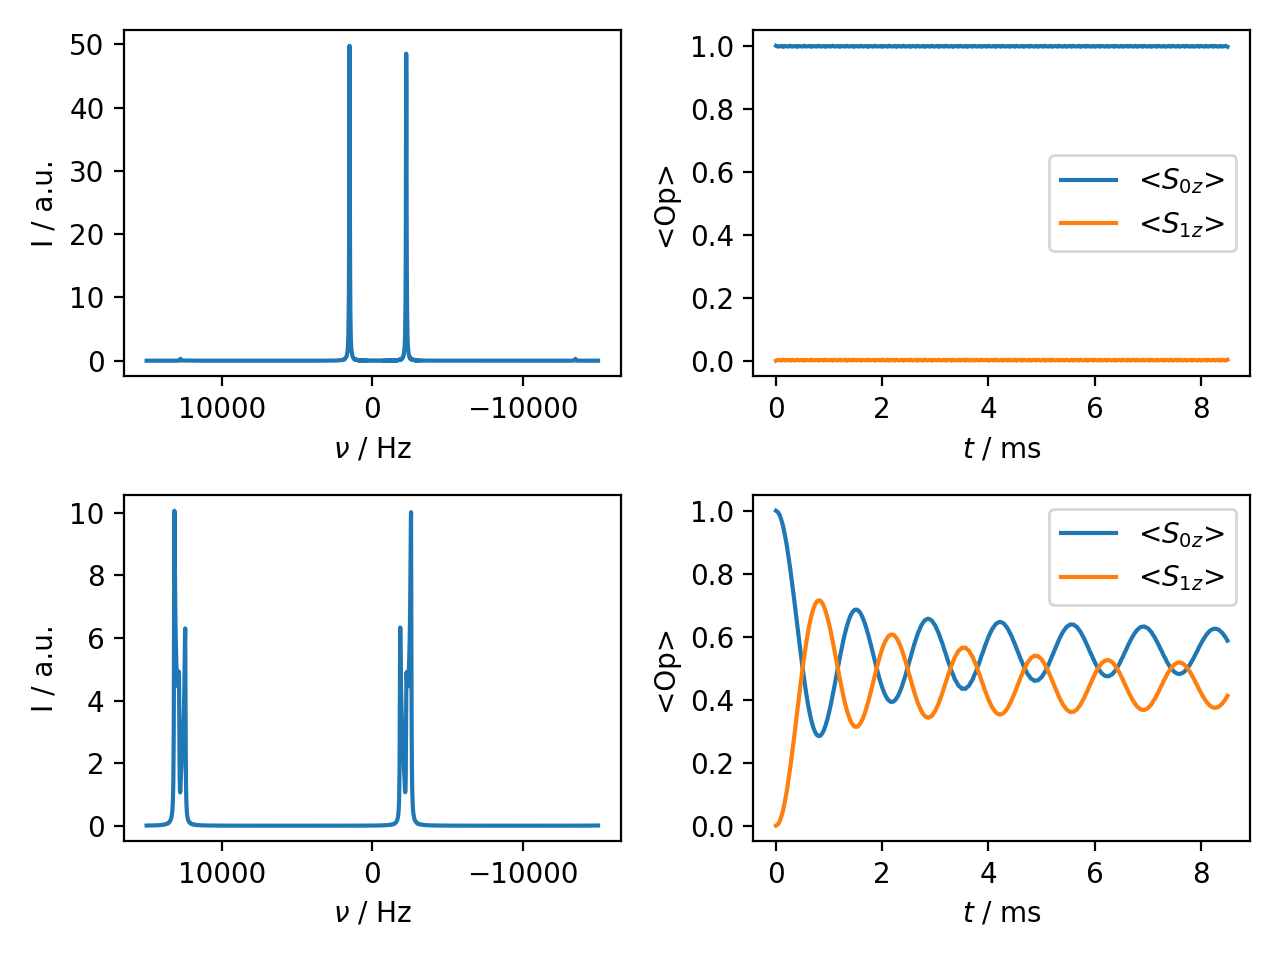

In [336]:
fig,ax=plt.subplots(2,2)
ax=ax.flatten()
for k,(rho,a) in enumerate(zip([Cx,Cz,CxRR,CzRR],ax)):
    rho.plot(FT=not(k%2),apodize=True,ax=a)
fig.tight_layout()

Being on rotary resonance transfers the magnetization effectively, but requires adjustment of the MAS to satisfy, and anyway destroys the spectrum as well. On the other hand, some broadening on the two spins introduces a small amount of overlap of the sideband of one peak to the centerband of the other. We will demonstrate slow transfer well away from the rotary resonance condition.

In [50]:
ex.set_inter('CS',ppm=10,i=0)
ex=sl.ExpSys(600,Nucs=['13C','13C'],vr=15000,pwdavg=sl.PowderAvg(q=4),n_gamma=30)
ex.set_inter('dipole',delta=dCC,i0=0,i1=1)
ex.set_inter('CS',ppm=-15,i=1)
ex.set_inter('CS',ppm=10,i=0)

L=ex.Liouvillian()
L.add_relax(Type='T2',i=0,T2=.001)
L.add_relax(Type='T2',i=1,T2=.001)

seq=L.Sequence()
seq.add_channel('13C',t=[0,L.taur/2])

Cx=sl.Rho('13Cx','13Cp')
Cx.DetProp(seq,n=1024)

Cz=sl.Rho('S0z',['S0z','S1z'])
seq.add_channel('13C',t=[0,L.taur])
U=L.U()**10
_=Cz.DetProp(U,n=1600)

Prop: 2 steps per every 1 rotor period


<IPython.core.display.Javascript object>


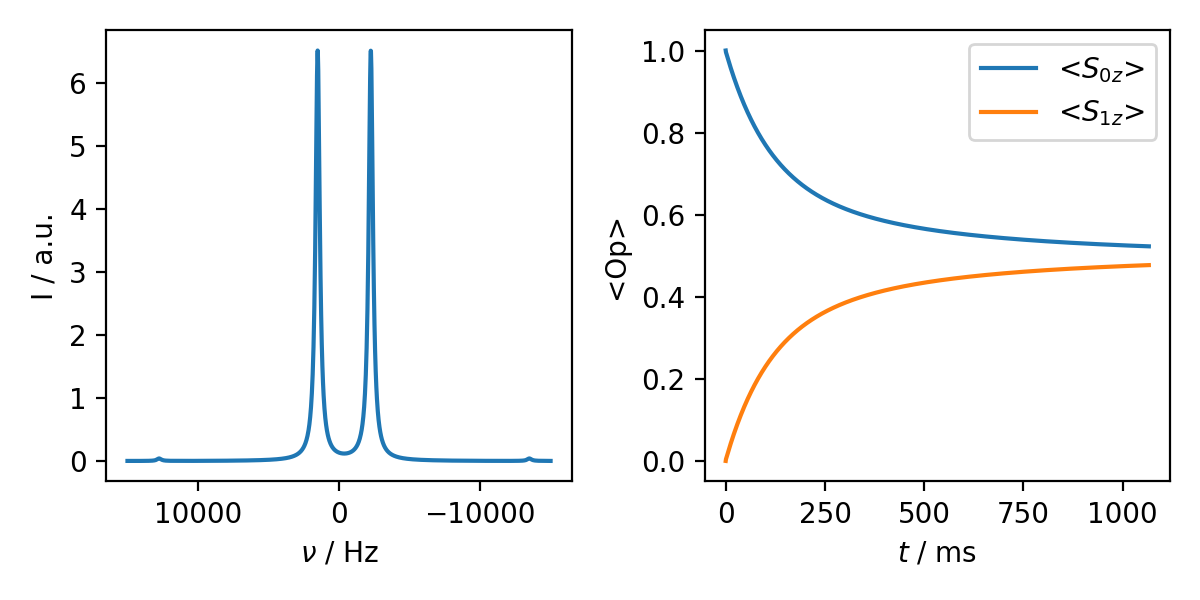

In [51]:
fig,ax=plt.subplots(1,2)
ax=ax.flatten()
for k,(rho,a) in enumerate(zip([Cx,Cz],ax)):
    rho.plot(FT=not(k%2),apodize=True,ax=a)
fig.set_size_inches([6,3])
fig.tight_layout()

# PDSD
We can induce spin-diffusion between the $^{13}$C by adding some broadening, but how might that broadening come from the protons, hence Proton Driven Spin Diffusion (PDSD)?

In the following simulation, we do not introduce any broadening on the $^{13}$C directly, but couple both carbons to a $^1$H, which itself undergoes spin flips (we induce a kind of artificial spin-diffusion).

In [344]:
ex.set_inter('CS',ppm=10,i=0)
ex=sl.ExpSys(600,Nucs=['13C','13C','1H'],vr=15000,pwdavg=sl.PowderAvg(q=2),n_gamma=30)
ex.set_inter('dipole',delta=dCC,i0=0,i1=1,euler=[0,30*np.pi/180,0])
ex.set_inter('CS',ppm=30,i=1)
ex.set_inter('CS',ppm=-20,i=0)
ex.set_inter('dipole',delta=dHC,i0=1,i1=2)

L=ex.Liouvillian()
L.add_relax(Type='SpinDiffusion',i=2,k=300)

seq=L.Sequence()
seq.add_channel('13C',t=[0,L.taur/2])

Cx=sl.Rho('13Cx','13Cp')
Cx.DetProp(seq,n=1024)

Cz=sl.Rho('S0z',['S0z','S1z'])
seq.add_channel('13C',t=[0,L.taur])
U=L.U()**10
_=Cz.DetProp(U,n=1600)

Prop: 2 steps per every 1 rotor period


<IPython.core.display.Javascript object>


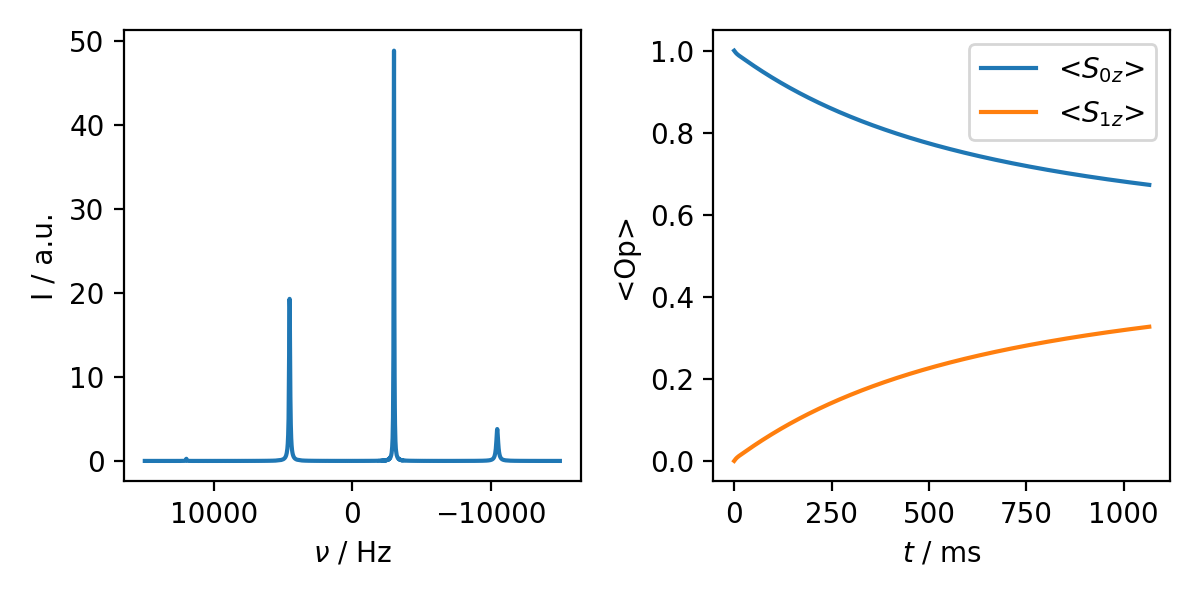

In [345]:
fig,ax=plt.subplots(1,2)
ax=ax.flatten()
for k,(rho,a) in enumerate(zip([Cx,Cz],ax)):
    rho.plot(FT=not(k%2),apodize=True,ax=a)
fig.set_size_inches([6,3])
fig.tight_layout()

# DARR
Finally, what about the DARR experiment? In this experiment, we have the same system as before, but we irradiate the $^1$H at the rotary resonance condition, re-introducing the H–C couplings, and thereby adding additional broadening to the $^{13}$C resonances.

In [350]:
ex.set_inter('CS',ppm=10,i=0)
ex=sl.ExpSys(600,Nucs=['13C','13C','1H'],vr=15000,pwdavg=sl.PowderAvg(q=4),n_gamma=30)
ex.set_inter('dipole',delta=dCC,i0=0,i1=1,euler=[0,30*np.pi/180,0])
ex.set_inter('CS',ppm=30,i=1)
ex.set_inter('CS',ppm=-20,i=0)
ex.set_inter('dipole',delta=dHC,i0=1,i1=2)

L=ex.Liouvillian()
L.add_relax(Type='SpinDiffusion',i=2,k=300)

seq=L.Sequence()
seq.add_channel('1H',t=[0,L.taur/4],v1=0)

Cx=sl.Rho('13Cx','13Cp')
Cx.DetProp(seq,n=1024)

Cz=sl.Rho('S0z',['S0z','S1z'])
seq.add_channel('1H',t=[0,L.taur],v1=0)
U=seq.U()**10
_=Cz.DetProp(U,n=1600)

seq=L.Sequence()
seq.add_channel('1H',t=[0,L.taur/4],v1=15000)

CxDARR=sl.Rho('13Cx','13Cp')
CxDARR.DetProp(seq,n=1024)

CzDARR=sl.Rho('S0z',['S0z','S1z'])
seq.add_channel('1H',t=[0,L.taur],v1=15000)
U=seq.U()**10
_=CzDARR.DetProp(U,n=1600)

Prop: 4 steps per every 1 rotor period
Prop: 4 steps per every 1 rotor period


<IPython.core.display.Javascript object>


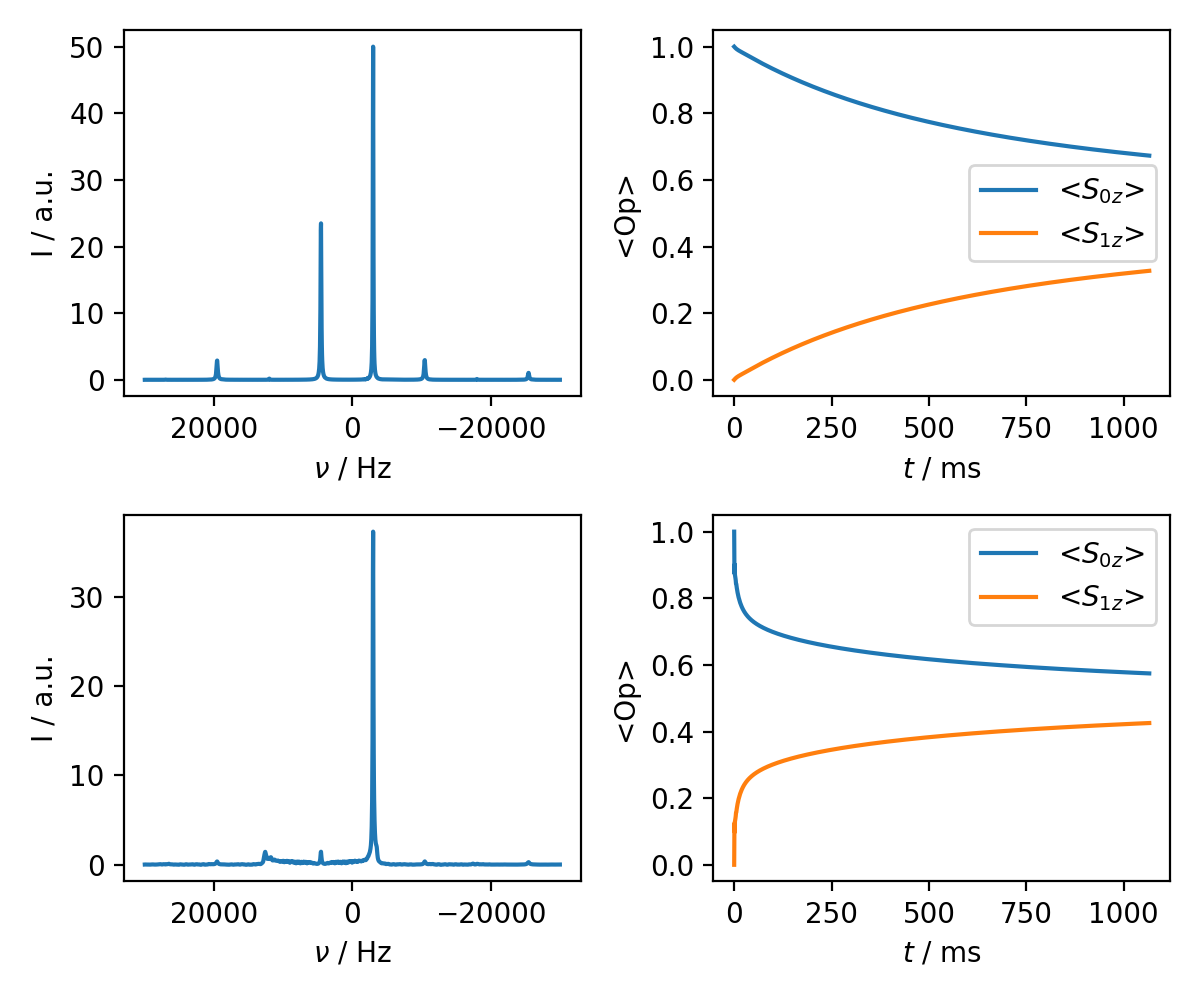

In [351]:
fig,ax=plt.subplots(2,2)
ax=ax.flatten()
for k,(rho,a) in enumerate(zip([Cx,Cz,CxDARR,CzDARR],ax)):
    rho.plot(FT=not(k%2),apodize=True,ax=a)
fig.set_size_inches([6,5])
fig.tight_layout()

In [352]:
ex.set_inter('CS',ppm=10,i=0)
ex=sl.ExpSys(600,Nucs=['13C','13C','1H'],vr=15000,pwdavg=sl.PowderAvg(q=4),n_gamma=30)
ex.set_inter('dipole',delta=dCC,i0=0,i1=1,euler=[0,30*np.pi/180,0])
ex.set_inter('CS',ppm=-15,i=1)
ex.set_inter('CS',ppm=10,i=0)
ex.set_inter('dipole',delta=dHC,i0=1,i1=2)

L=ex.Liouvillian()
L.add_relax(Type='SpinDiffusion',i=2,k=300)

seq=L.Sequence()
seq.add_channel('1H',t=[0,L.taur/4],v1=0)

Cx=sl.Rho('13Cx','13Cp')
Cx.DetProp(seq,n=1024)

Cz=sl.Rho('S0z',['S0z','S1z'])
seq.add_channel('1H',t=[0,L.taur],v1=0)
U=seq.U()**10
_=Cz.DetProp(U,n=1600)

seq=L.Sequence()
seq.add_channel('1H',t=[0,L.taur/4],v1=15000)

CxDARR=sl.Rho('13Cx','13Cp')
CxDARR.DetProp(seq,n=1024)

CzDARR=sl.Rho('S0z',['S0z','S1z'])
seq.add_channel('1H',t=[0,L.taur],v1=15000)
U=seq.U()**10
_=CzDARR.DetProp(U,n=1600)

Prop: 4 steps per every 1 rotor period
Prop: 4 steps per every 1 rotor period


<IPython.core.display.Javascript object>


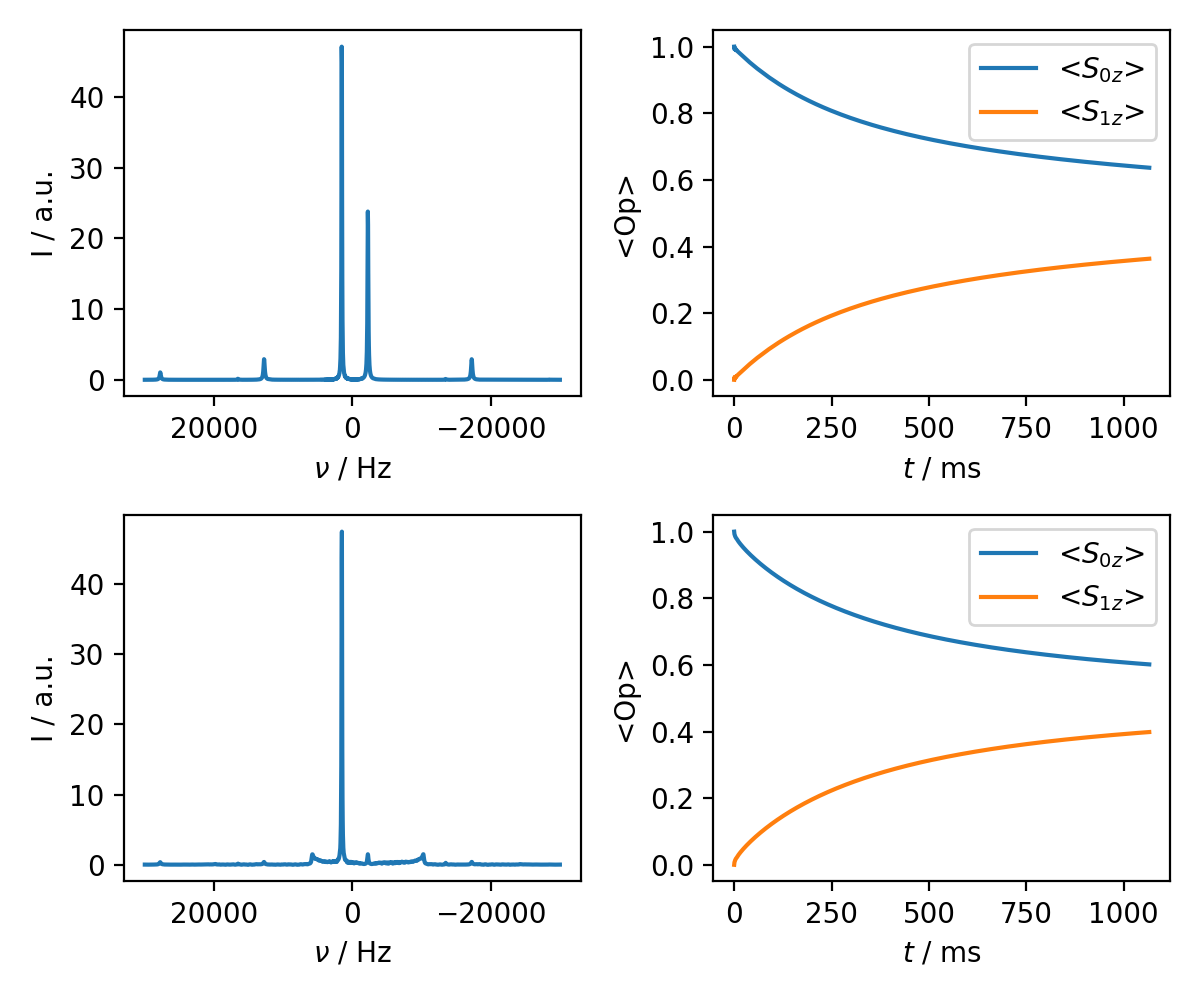

In [353]:
fig,ax=plt.subplots(2,2)
ax=ax.flatten()
for k,(rho,a) in enumerate(zip([Cx,Cz,CxDARR,CzDARR],ax)):
    rho.plot(FT=not(k%2),apodize=True,ax=a)
fig.set_size_inches([6,5])
fig.tight_layout()